# **Analysis of My Netflix Data**

Netflix allows you to download your own data and I thought this would be a neat project to do. I figure I could discover some neat trends among my profile and how the data compares to the other profiles on my account. Overall, I enjoyed doing some exploratory analysis of my own data. Netflix provides a whole zip file of several folders of data. Will be curious to peer through the other folders and see if any are worth analyzing. I was disappointed genres weren't included in this CSV. I was looking forward to discover how my past and current tastes had changed, or perhaps even remained the same. 

### Key Takeaways
Having had my account for 13 years now, I had forgotten and was reminded of how much past data my account carried. My account was way more active in the past, due to sharing my account amongst my friends, and discovered that a lot of this data was still making a sizeable impact on the data. For example, my Xbox 360 was still the most watched device, haven't hadthat for a long time now. Also, the most watched hours we're around in the early morning hours, something carried over from my friends watching Netflix after their night shifts. I wasn't aware of Supplemental Video Type data (trailers, previews, etc) either, makes sense these would be tracked as a metric also.

### To Do
- Find a way to include genre data
- Add recent viewing data to new dataframe to get a cleaer picture of my viewing trends recently


In [36]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv('../Netflix Analysis/Data/CONTENT_INTERACTION/ViewingActivity.csv')

## Explore and Clean Dataframe

In [37]:
# Get some prelimnary data
df.shape
df.head

<bound method NDFrame.head of       Profile Name           Start Time  Duration  \
0           Johnny  2023-08-30 04:45:43  00:00:13   
1           Johnny  2023-08-30 04:44:40  00:00:04   
2           Johnny  2023-08-30 04:44:22  00:00:14   
3           Johnny  2023-08-28 02:35:48  00:23:17   
4           Johnny  2023-08-25 06:31:22  00:01:45   
...            ...                  ...       ...   
46098         Meno  2014-10-15 09:08:42  00:39:21   
46099         Meno  2014-10-15 08:26:09  00:42:28   
46100         Meno  2014-10-15 05:42:27  02:42:05   
46101         Meno  2014-10-14 16:18:20  00:00:03   
46102         Meno  2014-10-14 04:59:46  05:21:03   

                            Attributes  \
0      Autoplayed: user action: None;    
1      Autoplayed: user action: None;    
2      Autoplayed: user action: None;    
3                                  NaN   
4                                  NaN   
...                                ...   
46098                              NaN 

In [38]:
# Retrieve all profile names on the account
df["Profile Name"].unique()

# Changing names to make more sense for the reader
df['Profile Name'] = df['Profile Name'].replace(['Lauren','Meno','Mama bear','Johnny'],['Girlfriend','Brother','Mom','Myself'])

# Check out the data types
df.dtypes

Profile Name               object
Start Time                 object
Duration                   object
Attributes                 object
Title                      object
Supplemental Video Type    object
Device Type                object
Bookmark                   object
Latest Bookmark            object
Country                    object
dtype: object

<p> Looks like the dtypes are all objects. To plot and perform analyis on these columns, we'll need to convert and split some of them. Let's begin by transforming dtypes of Start Time and Duration and then we'll confirm the changes by previewing the dataframe </p>

In [39]:
# Convert dtypes
df['Start Time'] = pd.to_datetime(df['Start Time'], utc=True)
df['Duration'] = pd.to_timedelta(df['Duration'])

# Split Start Time into four new columns (day, month, year, time)
df['Hour'] = df['Start Time'].dt.hour
df['Day'] = df['Start Time'].dt.day
df['Month'] = df['Start Time'].dt.month
df['Year'] = df['Start Time'].dt.year
df['Time'] = df['Start Time'].dt.time

# Find out which weekday it is and add a new column for that
df['Weekday'] = df['Start Time'].dt.day_name()
# Drop Start Time
df = df.drop(['Start Time'], axis=1)

# Verify the dtypes we're changed
display(df.dtypes)
# Get a random sample of 10 rows
df.sample(n=5)

Profile Name                        object
Duration                   timedelta64[ns]
Attributes                          object
Title                               object
Supplemental Video Type             object
Device Type                         object
Bookmark                            object
Latest Bookmark                     object
Country                             object
Hour                                 int64
Day                                  int64
Month                                int64
Year                                 int64
Time                                object
Weekday                             object
dtype: object

,Profile Name,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country,Hour,Day,Month,Year,Time,Weekday
11445,Myself,0 days 00:01:06,NaN,Futurama: Season 9: Zapp Dingbat (Episode 5),NaN,FireTV STB 2015,00:21:27,Not latest view,US (United States),4,18,11,2016,04:15:05,Friday
9158,Myself,0 days 00:21:49,NaN,Malcolm in the Middle: Season 4: Long Drive (E...,NaN,Vizio MG143 Wistron MT5580 NF Smart TV,00:21:49,00:21:49,US (United States),6,16,5,2017,06:45:50,Tuesday
30127,Mom,0 days 00:01:55,Autoplayed: user action: None;,Prayers for the Stolen - Upper Bound Clip 3,HOOK,Roku 3 Set Top Box,00:01:55,Not latest view,US (United States),5,21,1,2023,05:15:53,Saturday
2121,Myself,0 days 00:00:06,Autoplayed: user action: None;,ReMastered: The Miami Showband Massacre (Trailer),TRAILER,Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV,00:00:06,00:00:06,US (United States),6,15,12,2021,06:42:25,Wednesday
23413,Myself,0 days 00:22:02,NaN,The Office (U.S.): Season 7: The Seminar (Epis...,NaN,Microsoft Xbox 360,00:22:01,Not latest view,US (United States),6,21,12,2012,06:05:27,Friday


<p> Curious to see how many unique titles, seasons, and episodes have been watched on my account. Thankfully, Title separates each of these by a colon ':', so we'll split up Title into separate columns, and then drop Title so we don't keep repeated data. We'll also clean up the dataframe a bit by dropping other unnecessary columns.

In [40]:
# Split the Title column to create columns for the Number of Season and the Episode Name
df[['Film Title', '# of Season', 'Episode Name']] = df['Title'].str.split(':', n=2, expand=True)

# Drop columns that are not needed
df = df.drop(['Attributes', 'Bookmark', 'Latest Bookmark','Country','Title'], axis=1)

df.sample(n=5)

,Profile Name,Duration,Supplemental Video Type,Device Type,Hour,Day,Month,Year,Time,Weekday,Film Title,# of Season,Episode Name
30327,Mom,0 days 00:00:07,HOOK,Roku Nemo Set Top Box,5,18,12,2022,05:58:41,Sunday,The Princess Switch 3,Romancing the Star - Upper Bound Clip 13,None
2601,Myself,0 days 00:00:15,HOOK,Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV,8,6,9,2021,08:26:43,Monday,Season 1,Sensory Clip,Turning Point: 9/11 and the War on Terror
12082,Myself,0 days 00:02:38,NaN,FireTV STB 2015,1,7,10,2016,01:27:15,Friday,How to Get Away With Murder,Season 1,It's All Her Fault (Episode 2)
1281,Myself,0 days 00:19:44,NaN,Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV,5,17,11,2022,05:25:45,Thursday,Laguna Beach,Season 2,More Than Friends (Episode 4)
19880,Myself,0 days 00:21:54,NaN,PC,22,12,1,2014,22:59:41,Sunday,That '70s Show,Season 7,2000 Light Years from Home (Episode 22)


In [41]:
df['Supplemental Video Type'].value_counts()

HOOK              2911
TRAILER           1410
TEASER_TRAILER     266
RECAP               14
PREVIEW              6
PROMOTIONAL          5
BUMPER               2
Name: Supplemental Video Type, dtype: int64

 <p> After inspecting the dataframe, it appears there's a lot of viewings with short Durations. Each of these contained data in the Supplemental Video Type column - actual viewings contained NaN values in this column. The above counts showed that Supplemental Video Type we're trailers, hooks, previews, or other short promos, but they aren't true viewing interactions. Ultimately, these aren't needed for our analysis and should be removed so they don't muddy the data. Let's do that</p>

In [42]:
# Remove not null values aka only keep null
df = df[df['Supplemental Video Type'].isnull()]
# Confirm they we're removed
df['Supplemental Video Type'].value_counts()
# Drop supplemental now that rows we want are gone
df = df.drop(['Supplemental Video Type'], axis=1)

# See how many total interactions each profile has
df['Profile Name'].value_counts()

Myself        27219
Brother       12377
Mom            1276
Kids            469
Girlfriend      148
Name: Profile Name, dtype: int64

<p> Viewing interactions can be counted as each time the app has been opened per profil. I've clearly taken the lead with 27,219 interactions. Next place is 12,377 interactions, more than double! </p>

---

## Analyze Viewing Data

<p> Now that our dataframe is cleaned up, time to do some exploratory analysis and plot some data. Let's utilize the Film Title column and see how many unique titles or shows have been watched.

In [43]:
# Get a count of unique films or series
films_unique = df['Film Title'].unique()
len_films_unique = len(films_unique)

print("Total # of Unique Titles: ",len_films_unique)

Total # of Unique Titles:  4309


<p> Clearly, I've seen a lot of titles/shows across my acount. Let's create a table and see the top 10 most watched titles </p>

In [44]:
# A table that shows the top 10 most watched films/series across all profiles
top10 = df.groupby(['Film Title'])['Duration'].sum().nlargest(10)
top10_as_string = top10.astype(str)

table = go.Figure(data=[go.Table(
    header=dict(values=('Title', 'Total Time Watched'),
                fill_color='#abcabc',
                line_color='#dfd7ca',
                align='left'),
    cells=dict(values=[top10.index, top10_as_string],
               fill_color='white',
               line_color='#abcabc',
               align='left'),
)])
table.update_layout(title_text="Top 10 Series", title_x=0.5,width=700,height=450)

<p> When I used to share my account among friends, one of them was a dedicated Malcom in the Middle fan. To my surprise, it's still the most watched show on my account - that's some serious dedication! </p>

<p> Next, let's sum up and see how much overall time has been spent watched on my account and per profile. </p>

In [45]:
# Total time in hours spent watching Netflix
df['Duration in Hours'] = df['Duration'].dt.total_seconds()
df['Duration in Hours'] = df['Duration in Hours']/3600
duration_hours = int(df['Duration in Hours'].sum())

print("Total # of Hours Watched Across All Profiles: ",duration_hours)

Total # of Hours Watched Across All Profiles:  19199


In [46]:
# Get a sum of viewing time per each profile
display(df.loc[df['Profile Name']=='Myself','Duration'].sum())
display(df.loc[df['Profile Name']=='Brother','Duration'].sum())
display(df.loc[df['Profile Name']=='Mom','Duration'].sum())
display(df.loc[df['Profile Name']=='Kids','Duration'].sum())
display(df.loc[df['Profile Name']=='Girlfriend','Duration'].sum())

Timedelta('498 days 15:40:44')

Timedelta('254 days 11:28:39')

Timedelta('32 days 08:13:51')

Timedelta('11 days 21:18:19')

Timedelta('2 days 14:52:39')

<p> Appears I have 499 days worth of viewing time on my profile, about 1 1/2 years worth of time spent watching TV Shows and movies - a bit suprised by this. I know I've had my account for a long time though, so to put things into perspective, let's see how much time has spanned across my profile by sorting through the years. </p>

In [47]:
# Use sort_values() to see the range of time on my profile
df.loc[df['Profile Name']=='Myself','Year'].sort_values()

28886    2010
28507    2010
28508    2010
28509    2010
28510    2010
         ... 
655      2023
656      2023
657      2023
662      2023
3        2023
Name: Year, Length: 27219, dtype: int64

<p> My profile dates back 13 years ago till 2010. When looking at it through that lens, the total viewing time on my profile seems less drastic spread across more than a decade of time. </p>

<p> Next, let's plot total viewing time across all profiles. To do so, we'll need to create a dictionary to store each profile's viewing time in. We'll also need to convert the dtype of Duration. Matplotlib cannot natively plot the dtype timedelta and requires a singular integer value, so we'll convert Duration to hours using astype() </p>

In [48]:
# Create a dictionary to store a sum of viewing time per profile
viewTime = {}
# Convert timedelta to minutes using astype 
viewTime.update({"Myself": df.loc[df['Profile Name']=='Myself','Duration'].astype('timedelta64[h]').sum()})
viewTime.update({"Brother": df.loc[df['Profile Name']=='Brother','Duration'].astype('timedelta64[h]').sum()})
viewTime.update({"Mom": df.loc[df['Profile Name']=='Mom','Duration'].astype('timedelta64[h]').sum()})
viewTime.update({"Kids": df.loc[df['Profile Name']=='Kids','Duration'].astype('timedelta64[h]').sum()})
viewTime.update({"Girlfriend": df.loc[df['Profile Name']=='Girlfriend','Duration'].astype('timedelta64[h]').sum()})

viewTime

{'Myself': 2100.0,
 'Brother': 1307.0,
 'Mom': 187.0,
 'Kids': 151.0,
 'Girlfriend': 12.0}

<p> My girlfriend has only recently created her profile on my account, so that's not much of a surprise how much little time that profile has. No error in the data there. Let's plot the data and visualize total time wached per profile.  </p>

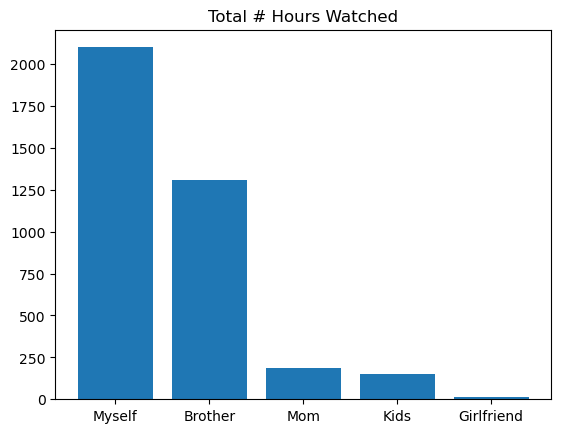

In [49]:
# Use *zip to iterate over the key/values in viewTime dictionary and plot
plt.bar(*zip(*viewTime.items()))
plt.title("Total # Hours Watched")

plt.show()

<p> I'm curious to see a general consensus of days of the week Netflix has been watched the most on my account across all profiles. I'll use plotly for this one, since it's a bit more interactive and more visually pleasing. This way we can also play with the pie chart and see what insights we can draw with the percentages as it changes with only weekdays, weekends, etc. </p>

In [50]:
# A pie chart that shows the days of the week that Netflix was watched across all profiles
pie_chart = px.pie(df['Weekday'], names='Weekday', hole=.4,
                   title='A Week of Watching Netflix',
                   color_discrete_sequence=px.colors.qualitative.T10,
                   )
pie_chart.update_traces(textposition='inside', textinfo='percent+label', textfont_size=10)
pie_chart.update_layout(title_x=0.5,width=600,height=400)

<p> It's a small difference, but overall, the week days are the most watched days. Makes sense given those are the days people are most at home. Will see if that trend remains the same for my profile, my guess would be yes since my profile has the most impact on the data, but will verify that. </p>

<p> Let's see how much time on average each profile spends watching per viewing. From what I've gathered earlier, each episode watched counts as an interaction. So if a user watches more movies, they may have more time on average per viewing, and vice versa with someone who tends to watches more TV shows. </p>

<p> Using the totals of individual profile interactions from earlier, let's divide Duration by total interactions to get an average viewing time for each user. </p>

In [51]:
display(df.loc[df['Profile Name']=='Myself','Duration'].sum()/27219)
display(df.loc[df['Profile Name']=='Brother','Duration'].sum()/12377)
display(df.loc[df['Profile Name']=='Mom','Duration'].sum()/1276)
display(df.loc[df['Profile Name']=='Kids','Duration'].sum()/469)
display(df.loc[df['Profile Name']=='Girlfriend','Duration'].sum()/148)

Timedelta('0 days 00:26:22.851831441')

Timedelta('0 days 00:29:36.433626888')

Timedelta('0 days 00:36:29.992946708')

Timedelta('0 days 00:36:29.976545842')

Timedelta('0 days 00:25:29.452702702')

<p> Seems on average it's about 28-30 minutes per viewing. Since episodes make up a higher count of viewing interactions, these are going to make a bigger impact on the data and shorten the average. </p>

<p> I'm overall more curious in trends regarding my specific profile, so let's create a new dataframe for my profile and do some analysis on that. </p>

In [52]:
df_myself= df.loc[df['Profile Name']=='Myself']
# A line chart that showcases my Netflix behaviour through the years.
year_clustered = df_myself.groupby('Year').sum(numeric_only=True).reset_index()
line_chart = px.line(year_clustered, x='Year', y='Duration in Hours',
                     title='My Netflix Watching Over the Years')
line_chart.update_layout(title_x=0.5, plot_bgcolor='#FBF9F9', width=800, height=400)
line_chart.update_traces(line_color="mediumblue", line_width=3)

<p> Pandas by default sorts data in descending order. Not typically an issue, but our data is describing days, so it makes more sense to visualize the data in order by day of the week (Monday-Sunday). To do this, we'll use pd.Categorical to create categories from the days and sort them in numerical order. Then we'll do the same for hourly data. </p>

<p> For the small amount of data I'm working with here, using categories wasn't exactly necessary, it's just a bit more efficient. For larger data sets, the difference is more noticeable. </p>

In [53]:
df_myself['Weekday'].value_counts()

Tuesday      4159
Monday       4069
Thursday     4059
Friday       4012
Wednesday    3927
Saturday     3529
Sunday       3464
Name: Weekday, dtype: int64

In [66]:
# Count and sort day
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

df_myself = df_myself.reset_index(drop = True)

df_myself['Weekday'] = pd.Categorical(df_myself['Weekday'], categories=weekdays, ordered=True)

days_clustered = df_myself.groupby('Weekday').sum(numeric_only=True).reset_index()
line_chart = px.line(days_clustered, x='Weekday', y='Duration in Hours',
                     title='My Netflix Watching by Days of the Week')
line_chart.update_layout(title_x=0.5, plot_bgcolor='#FBF9F9', width=800, height=400)
line_chart.update_traces(line_color="mediumblue", line_width=3)

<p> There's only a marginal difference, but it seems on week days I watched more Netflix. This was kind of expected, on those days I'm spending more time at home watching TV. Curious about the dip on Wednesday, that I'm still unsure why. </p>

<p> Now let's see which hours of the day we're most popular to watch Netflix </p>

In [64]:
hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

df_myself['Hour'] = pd.Categorical(df_myself['Hour'], categories=hours, ordered=True)

hours_clustered = df_myself.groupby('Hour').sum(numeric_only=True).reset_index()
line_chart = px.line(hours_clustered, x='Hour', y='Duration in Hours',
                     title='My Netflix Watching by the Hour')
line_chart.update_layout(title_x=0.5, plot_bgcolor='#FBF9F9', width=800, height=400)
line_chart.update_traces(line_color="mediumblue", line_width=3)

<p> The data overall makes sense, I figured the trend would show there'd be more viewings in the morning and at night, but according to the data, the hours most watched we're 5-6AM. As previously mentioned, I used to share my account among a handful of friends and a couple of them would work night shifts, I suspect this was their viewings in the early morning hours. </p>

---

## Analyze Device Data

<p> Let's see which device has been most used by getting a count of each value in Device Type and plot the data. </p>

In [56]:
df['Device Type'].value_counts().head(10)

FireTV Stick 2014                                 6152
Microsoft Xbox 360                                5906
Amazon Fire TV Stick 2020 Lite Streaming Stick    4694
PC                                                3566
Vizio MG143 Wistron MT5580 NF Smart TV            3016
Roku 3 Set Top Box                                2380
Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV       2084
FireTV STB 2015                                   1761
Vizio MG132 eMMC MT5580 TPV Smart TV              1426
WiiU                                              1188
Name: Device Type, dtype: int64

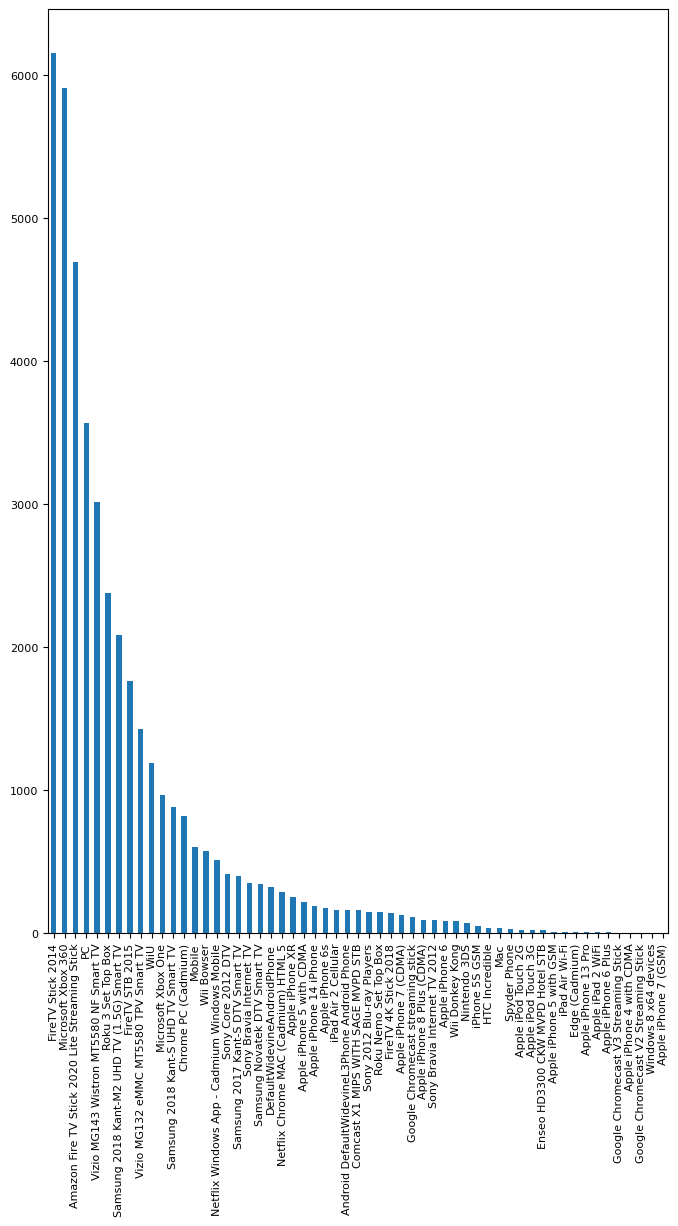

In [94]:
df['Device Type'].value_counts().plot(kind='bar',fontsize=8,figsize=(8,12))

plt.show()

<p> Across all profiles, appears an Amazon Fire Stick was the most used device to watch Netflix, not too surprised with that one, my family had a Fire Stick they'd all use to centrally watch. What I'm more taken back by is that I haven't had an Xbox 360 for 6 or 7 years now and it <em>still</em> ranks as the third most watched device, this was the device I'd use. Let's examine the devices on my profile. </p>

In [58]:
# Get top 5 most used devices
df_myself['Device Type'].value_counts().head(5)

Microsoft Xbox 360                             5859
PC                                             3462
Vizio MG143 Wistron MT5580 NF Smart TV         3016
Samsung 2018 Kant-M2 UHD TV (1.5G) Smart TV    2054
Roku 3 Set Top Box                             1515
Name: Device Type, dtype: int64

<p> On my specific profile, my old Xbox 360 still has the most viewing interactions - didn't realize how much I used this device. </p>

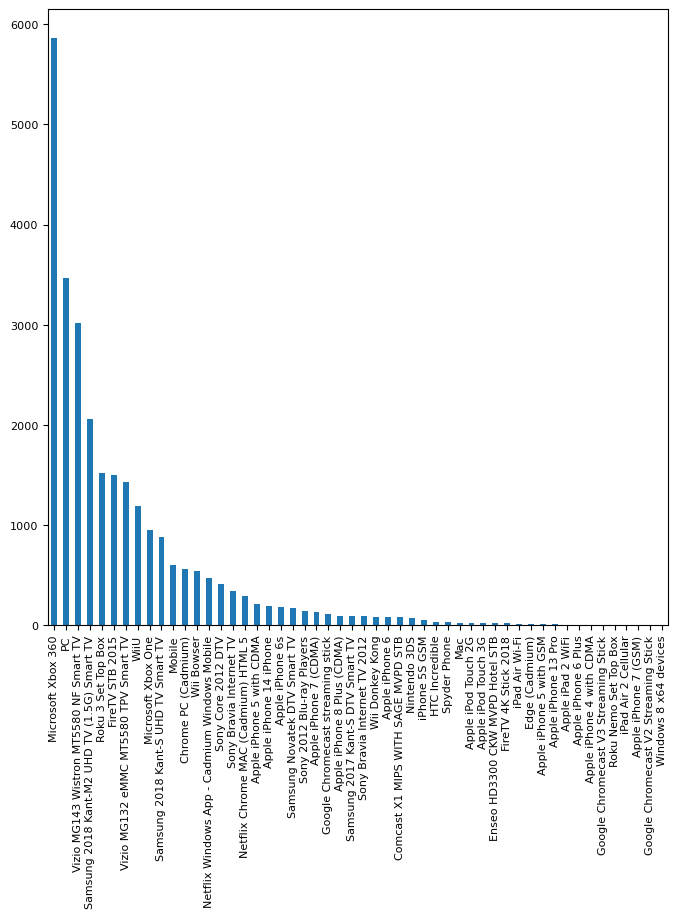

In [106]:
df_myself['Device Type'].value_counts().plot(kind='bar',fontsize=8,figsize=(8,8))

plt.show()